## Background

Consider the problem of constructing a binary classifier for a set of binary features. This problem has a host of practical applications. For example, the binary features can be interpreted as readings from a network of sensors or a fleet of autonomous vehicles and the labels can indicate an overall state of the network / vehicle (safe or fail). In general, these systems have a complex behavior and cannot be modeled exactly to specify the feature-label mapping $f$. Machine learning solutions are deployed ubiquitously to “learn” the  mapping $f$ by using e.g. supervised learning and training sets. Here, we explore how quantum computers can be utilized to solve this problem. 

## Problem Formulation 

We wish to assign binary labels ${\bf y}=\{0,1\}$ to a set of $N$-bit feature vectors ${\bf x}_i=\{x_{i1},\cdots,x_{iN}\}$ ($x_{ij}=\{0,1\}$). We assume that there is an unknown Boolean function $f({\bf x})$ that maps a feature vector onto a corresponding binary label ${\bf y}$ i.e. ${\bf y}=f({\bf x})$. We do not know $f$ but, given some fitness metric $L$ and a training set $T$ of observed features ${\bf x}_i$ and corresponding labels ${\bf y}_i$ ($T=\{{\bf x}_i, {\bf y}_i\}$,$i=1,M$), we would like to construct a quantum circuit $\mathcal{C}$ such that it minimizes $L$ and reproduces the labels of the set T with the total error $\le \epsilon$ for some pre-specified $\epsilon\ge 0$. Then we can use the circuit $\mathcal{C}$ to classify features outside of the training set $T$.

To cast the binary classification problem into a form acceptable by a quantum computer, we need to

- Specify a mapping of classical features $\{{\bf x}_i\}$ onto quantum states of a register of qubits $\{|\psi_i\rangle \}$.
- Specify a quantum circuit $\mathcal{C}(\{\vec{\theta},\vec{\phi}\})$ (a sequence of elementary single- and two-qubit gates) that transforms the input states $\{|\psi_i\rangle \}$ into output states $\{|\phi_i\rangle \}$ ($|\phi_i\rangle = \mathcal{C}|\psi_i\rangle $). The circuit $\mathcal{C}(\{\vec{\theta},\vec{\phi}\})$ depends on classical parameters $\{\vec{\theta},\vec{\phi}\}$ that can be adjusted to change the output $\{|\phi_i\rangle \}$ .
- Specify a measurement (Hermitian operator $M$) to perform on the output states $\{|\phi_i\rangle \}$.

If the form of the function $f$ that maps features $\{{\bf x}_i\}$ into labels ${\bf y}=f({\bf x})$ were known then we could construct a corresponding quantum circuit $\mathcal{C}_f$, such that $\mathcal{C}_f∣\psi_i\rangle∣0⟩=∣\psi_i\rangle∣f({\bf x})\rangle$ for all binary features ${\bf x}$, using, e.g., basic quantum arithmetic (adder) circuits. A more realistic scenario is when $f$ is unknown. In this case we will construct a quantum circuit $\mathcal{C}(\{\vec{\theta},\vec{\phi}\})$, where single-qubit and two-qubit quantum gates depend on continuous parameters $\vec{\theta} = \{\theta_1,\cdots,\theta_n\}$ and $\vec{\phi} = \{\phi_1,\cdots,\phi_m\}$ respectively, such that $\mathcal{C}$ approximates the action of $\mathcal{C}_f$ on features from the training set $T$ for some suitable parameter values $\{\vec{\theta}_0,\vec{\phi}_0\}$. The problem of finding parameters $\{\vec{\theta}_0,\vec{\phi}_0\}$ can be solved by using gradient training techniques i.e. by classical minimization of a loss function. For example, the loss function can be defined as the total distance between the output states of the quantum neural net $\mathcal{C}(\{\vec{\theta},\vec{\phi}\})$ and the states of the training set $T$. In this case the training task is

- ${\rm minimize}\sum\limits_{i\in T}\|\mathcal{C}(\{\vec{\theta},\vec{\phi}\})|\psi_i\rangle|0\rangle-|\psi_i\rangle|{\bf y}_i\rangle\|^2 $,

over all values of $\{\vec{\theta},\vec{\phi}\}$. We solve this training task by evaluating the loss function using quantum backend and updating parameters $\{\vec{\theta},\vec{\phi}\}$ classically in a e.g. a steepest descent loop. 

## Mapping binary features onto quantum states of qubits

There are many ways to map classical data onto quantum states of qubits. Arguably the simplest way, given the binary nature of our features, is to map $x_{ij}$ -- the $j$-th bit of the ${\bf x}_i$ feature bit string -- to the correspondent quantum state of the $j$-th qubit $∣x_{ij}\rangle$. Then ${\bf x}_i = \{x_{i1},\cdots,x_{iN}\}$ will be mapped onto the $N$-qubit state $∣{\bf x}_i\rangle=∣x_{i1}\rangle\otimes\cdots\otimes|x_{iN}\rangle=∣x_{i1},\cdots,x_{iN}\rangle$. Similarly, we will map the labels ${\bf y}_i$ onto the state $|{\bf y}_i\rangle$ of the label qubit. For example, the feature-label tuple $\{{\bf x}_i=00101010,{\bf y}_i=0\}$ will be represented by the quantum state $∣\psi_i\rangle =∣00101010\rangle∣0\rangle$. Here is how one could construct a quantum circuit that prepares the state $∣\psi_i\rangle$ using Amazon Braket:

In [1]:
# Import Braket libraries
from braket.circuits import Circuit
from braket.aws import AwsDevice

# A function that converts a bit string bitStr into a quantum circuit
def bit_string2circuit(bitStr):
   
    circuit = Circuit()
    for ind in range(len(bitStr)):
        if bitStr[ind]=='1':
            circuit.x(ind)
            
    return circuit
    
# provide a feature string from the example above
feature = '00101010'

# print quantum circuit that prepares corresponding quantum state 
print(bit_string2circuit(feature))

T  : |0|
        
q2 : -X-
        
q4 : -X-
        
q6 : -X-

T  : |0|


## Designing Quantum Neural Networks and Training

### Example 1: Parity-based labels.

For our first example, let us assume that labels ${\bf y}_i$ are generated by a Boolean function $f({\bf x}_i) = (\sum\limits_{j=1}^{N}x_{ij})\ {\rm mod}\ 2$. We will generate $M$ random $N$-bit feature strings and assign them labels according to $f$. This will be our training set $T$. For the quantum neural network $\mathcal{C}(\{\vec{\theta},\vec{\phi}\})$ that we will train to perform the classification, we will use the design layout depicted in Figure 1. It is has $4N+1$ classical parameters defining: $N$ two-qubit gates $XX(\phi_j) = e^{-i\phi_j \hat{X}_j\hat{X}_{N+1}}$ and $3N+1$ single-qubit gates $R_{x}(\theta_k) = e^{-i\theta_k\hat{X}_j}$ and $R_{y}(\theta_m) = e^{-i\theta_m\hat{Y}_j}$. We will use the $N+1$-th qubit to compute the label value after the quantum neural net acted on the initial state $|x_{i1},\cdots,x_{iN}\rangle|0\rangle$. In particular, we will encode the label in the expectation value $\langle\hat{Z}\rangle(\{\vec{\theta},\vec{\phi}\}) =\langle 0,{\bf x}_i|\tilde{\mathcal{C}}^{\dagger}(\{\vec{\theta},\vec{\phi}\})\hat{Z}_{N+1}\tilde{\mathcal{C}}(\{\vec{\theta},\vec{\phi}\})|{\bf x}_i,0\rangle$ of Pauli $\hat{Z}$ operator on the $N+1$-th qubit.  By definition, given the feature ${\bf x}_i$, $\langle\hat{Z}\rangle$ is a continuous function of the quantum neural net parameters $\{\vec{\theta},\vec{\phi}\}$ in the range $[−1,1]$. In the training of the quantum neural net circuit $\mathcal{C}$ our goal is to find a set of parameters $\{\vec{\theta}_o,\vec{\phi}_o\}$ that for each feature in the training set $T$ the label value ${\bf y}_i$ is close to $\frac{1-\langle\hat{Z}\rangle(\{\vec{\theta}_o,\vec{\phi}_o\})}{2}$. To achieve this, we will minimize the log loss function $L(\{\vec{\theta},\vec{\phi}\}) $ defined as,

$L(\{\vec{\theta},\vec{\phi}\})=-\sum\limits_{i=1}^{M}{\bf y}_i\log(\frac{1-\langle\hat{Z}\rangle (\{\vec{\theta},\vec{\phi}\} )}{2})+(1-{\bf y}_i)\log(\frac{1+\langle\hat{Z}\rangle(\{\vec{\theta},\vec{\phi}\})}{2})$.

We can use quantum backends to evaluate $L(\{\vec{\theta},\vec{\phi}\})$ and a classical optimizer (e.g. from scipy.optimize ) to minimize it. Here is how we can do it using Braket local simulator as a backend.

![Binary%20Classifier%20QML_Parity.png](attachment:Binary%20Classifier%20QML_Parity.png "Figure 1")
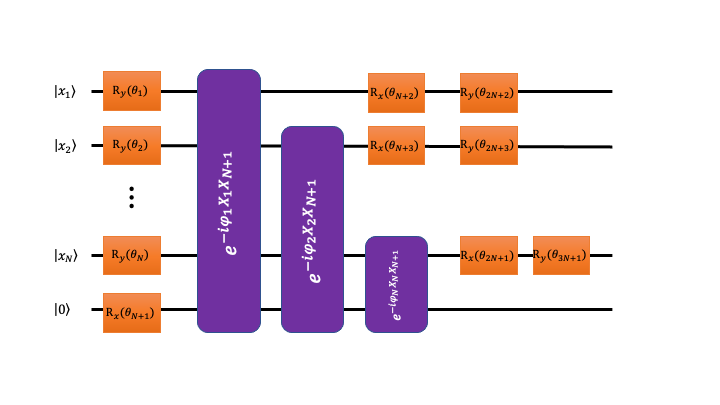

First let us construct the quantum neural net circuit.

In [2]:
# import standard numpy libraries and optimizers
import numpy as np
from scipy.optimize import minimize

# Braket imports
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import LocalSimulator

# set Braket backend to local simulator (can be changed to other backends)
device = LocalSimulator() 

# Quantum Neural Net from Figure 2 implemented in Braket
# Inputs: bitStr - feature bit string (e.g. '01010101')
#         pars - array of parameters theta and phi (see Figure 2 for more details) 

def QNN(bitStr,pars):
    ## size of the quantum neural net circuit
    nQbts = len(bitStr) + 1 # extra qubit is allocated for the label 
    
    ## initilize the circuit
    qnn = Circuit()
    
    ## add XX gate between qubit i and the label qubit, 
    ## single-qubit X and Y rotations, 
    ## and initilaize the input state to the one specified by bitStr
    qnn.rx(nQbts-1,pars[0])
    for ind in range(nQbts-1):
        angles = pars[4*ind + 1:4*ind+1+4]
        if bitStr[ind] == '1': # by default Braket sets input states to '0', 
                               # qnn.x(ind) flips qubit number ind to state |1\ 
            qnn.x(ind)
        qnn.ry(ind,angles[0]).xx(ind, nQbts-1, angles[1]).rx(ind,angles[2]).ry(ind,angles[3])
    
    ## add Z observable to the label qubit
    observZ = Observable.Z()
    qnn.expectation(observZ, target=[nQbts-1]) 
    
    return qnn

Next we will code up the log loss function $L(\{\vec{\theta},\vec{\phi}\})$ that we will minimize to train our binary classifier.

In [3]:
## Function that computes the label of a given feature bit sting bitStr

def parity(bitStr):
    count = 0
    for ind in range(len(bitStr)):
        if bitStr[ind]=='1':
            count+=1            
    return count%2

## Log loss function L(theta,phi) for a given training set trainSet
## inputs: trainSet - array of feature bit strings e.g. ['0101','1110','0000'] 
##         pars - quantum neural net parameters theta and phi (See Figure 2)
##         device -  Braket backend that will compute the log loss
def cost(trainSet,pars,device):
    cost = 0.0
    for ind in range(np.size(trainSet)):  
        ## run QNN on Braket device
        task = device.run(QNN(trainSet[ind],pars), shots=0) 
        ## retrieve the run results <Z>
        result = task.result()
          
        if parity(trainSet[ind])==0:
            cost += -np.log2(1.0-0.5*(1.0-result.values[0]))
        else:
            cost += -np.log2(0.5*(1.0-result.values[0]))
    print ("Current value of the loss function: ", cost)
    return cost

Putting it all together we can now train our quantum neural net to reproduce binary classification of a training set.

In [ ]:
## Training the QNN using gradient-based optimizer
nBits = 10 # number of bits per feature

## Random training set consisting of 11 10-bit features
## Please explore other training sets
trainSet = ['1101011010','1000110011','0101001001','0010000110','0101111010','0000100010','1001010000','1100110001','1000010001','0000111101','0000000001']

## Initial assignment of QNN parameters theta and phi (random angles in [-pi,pi]) 
pars0 = 2 * np.pi * np.random.rand((4*nBits+1)+1) - np.pi

## Run minimization
res = minimize(lambda pars: cost(trainSet,pars,device), pars0, method='BFGS', options={'disp':True})

Current value of the loss function:  11.063528476365125
Current value of the loss function:  11.063528476457787
Current value of the loss function:  11.063528474826576
Current value of the loss function:  11.063528469164469
Current value of the loss function:  11.063528476365127
Current value of the loss function:  11.063528476365125
Current value of the loss function:  11.063528475965331
Current value of the loss function:  11.063528477742825
Current value of the loss function:  11.063528476365125
Current value of the loss function:  11.063528476365125
Current value of the loss function:  11.063528480882711
Current value of the loss function:  11.063528472806594
Current value of the loss function:  11.063528476365127
Current value of the loss function:  11.063528476365127
Current value of the loss function:  11.063528477397838
Current value of the loss function:  11.0635284774927
Current value of the loss function:  11.063528476365125
Current value of the loss function:  11.0635284763

Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.299853115715674
Current value of the loss function:  17.29985314091384
Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.299853110519724
Current value of the loss function:  17.299853140426954
Current value of the loss function:  17.29985302289657
Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.29985311284175
Current value of the loss function:  17.299853056102936
Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.299853110519727
Current value of the loss function:  17.299853099578083
Current value of the loss function:  17.29985300418328
Current value of the loss function:  17.29985311051973
Current value of the loss function:  17.2998531105197

Current value of the loss function:  8.865458012717845
Current value of the loss function:  8.865458012717845
Current value of the loss function:  17.39171415143008
Current value of the loss function:  17.391714165674255
Current value of the loss function:  17.39171417649728
Current value of the loss function:  17.391714235014206
Current value of the loss function:  17.391714151430076
Current value of the loss function:  17.391714151430076
Current value of the loss function:  17.391714150125885
Current value of the loss function:  17.391714083285617
Current value of the loss function:  17.39171415143008
Current value of the loss function:  17.39171415143008
Current value of the loss function:  17.391714138482836
Current value of the loss function:  17.391714099368023
Current value of the loss function:  17.39171415143008
Current value of the loss function:  17.39171415143008
Current value of the loss function:  17.391714164480035
Current value of the loss function:  17.391714109880162


Current value of the loss function:  10.040421187507233
Current value of the loss function:  10.04042112640641
Current value of the loss function:  10.040421191999366
Current value of the loss function:  10.040421191999366
Current value of the loss function:  10.040421197807213
Current value of the loss function:  10.040421138686334
Current value of the loss function:  10.040421191999368
Current value of the loss function:  10.040421191999368
Current value of the loss function:  10.040421204007734
Current value of the loss function:  10.040421112723447
Current value of the loss function:  10.040421191999368
Current value of the loss function:  10.040421191999366
Current value of the loss function:  10.040421192320924
Current value of the loss function:  10.040421155735611
Current value of the loss function:  10.040421191999368
Current value of the loss function:  10.040421191999366
Current value of the loss function:  10.040421204034715
Current value of the loss function:  10.040421223

Current value of the loss function:  7.806655712853635
Current value of the loss function:  7.8066556797579745
Current value of the loss function:  7.806655713498319
Current value of the loss function:  7.806655713498318
Current value of the loss function:  7.806655713498319
Current value of the loss function:  7.408576339045481
Current value of the loss function:  7.40857634332832
Current value of the loss function:  7.408576340216118
Current value of the loss function:  7.408576376209699
Current value of the loss function:  7.408576339045481
Current value of the loss function:  7.408576339045481
Current value of the loss function:  7.408576341720387
Current value of the loss function:  7.40857628490188
Current value of the loss function:  7.40857633904548
Current value of the loss function:  7.40857633904548
Current value of the loss function:  7.408576332534519
Current value of the loss function:  7.408576358705741
Current value of the loss function:  7.40857633904548
Current value 

Current value of the loss function:  4.045959578240074
Current value of the loss function:  4.0459595838223805
Current value of the loss function:  4.0459595838223805
Current value of the loss function:  4.045959593334217
Current value of the loss function:  4.045959559158435
Current value of the loss function:  4.045959583822381
Current value of the loss function:  4.0459595838223805
Current value of the loss function:  4.045959583488641
Current value of the loss function:  4.045959559909368
Current value of the loss function:  4.0459595838223805
Current value of the loss function:  4.0459595838223805
Current value of the loss function:  4.045959595012286
Current value of the loss function:  4.045959568967467
Current value of the loss function:  4.045959583822381
Current value of the loss function:  4.0459595838223805
Current value of the loss function:  4.045959584890827
Current value of the loss function:  4.045959559780922
Current value of the loss function:  4.0459595838223805
Cur

Current value of the loss function:  2.1077344644631775
Current value of the loss function:  2.107734464771814
Current value of the loss function:  2.107734464771813
Current value of the loss function:  2.107734465379143
Current value of the loss function:  2.1077344659337793
Current value of the loss function:  2.1077344647718124
Current value of the loss function:  2.1077344647718137
Current value of the loss function:  2.1077344647718124
Current value of the loss function:  2.6769947490575596
Current value of the loss function:  2.6769947625240063
Current value of the loss function:  2.676994749059795
Current value of the loss function:  2.6769947456759624
Current value of the loss function:  2.676994749057559
Current value of the loss function:  2.6769947490575627
Current value of the loss function:  2.6769947500340137
Current value of the loss function:  2.6769947207155713
Current value of the loss function:  2.67699474905756
Current value of the loss function:  2.67699474905756
C

Current value of the loss function:  1.594447139559338
Current value of the loss function:  1.5944471364929855
Current value of the loss function:  1.594447136492986
Current value of the loss function:  1.5944471373859381
Current value of the loss function:  1.5944471261917559
Current value of the loss function:  1.5944471364929829
Current value of the loss function:  1.5944471364929842
Current value of the loss function:  1.5944471335733703
Current value of the loss function:  1.594447122702025
Current value of the loss function:  1.5944471364929849
Current value of the loss function:  1.5944471364929846
Current value of the loss function:  1.594447144777695
Current value of the loss function:  1.5944471318325484
Current value of the loss function:  1.5944471364929842
Current value of the loss function:  1.5944471364929853
Current value of the loss function:  1.5944471357441408
Current value of the loss function:  1.5944471236122306
Current value of the loss function:  1.5944471364929

Current value of the loss function:  0.8812207458465339
Current value of the loss function:  0.8812207448113315
Current value of the loss function:  0.8812207540853768
Current value of the loss function:  0.8812207458465342
Current value of the loss function:  0.8812207458465325
Current value of the loss function:  0.8812207501587588
Current value of the loss function:  0.881220745393763
Current value of the loss function:  0.8812207458465339
Current value of the loss function:  0.8812207458465343
Current value of the loss function:  0.8812207458871048
Current value of the loss function:  0.8812207473381355
Current value of the loss function:  0.8812207458465348
Current value of the loss function:  0.8812207458465338
Current value of the loss function:  0.8812207458465343
Current value of the loss function:  0.733628080688143
Current value of the loss function:  0.7336280782644918
Current value of the loss function:  0.7336280776788598
Current value of the loss function:  0.73362808025

Current value of the loss function:  0.6658568305047732
Current value of the loss function:  0.6658568280151689
Current value of the loss function:  0.6658568230857271
Current value of the loss function:  0.6658568305047736
Current value of the loss function:  0.6658568305047706
Current value of the loss function:  0.6658568306058915
Current value of the loss function:  0.6658568285564072
Current value of the loss function:  0.6658568305047731
Current value of the loss function:  0.6658568305047723
Current value of the loss function:  0.6658568329669596
Current value of the loss function:  0.6658568296773265
Current value of the loss function:  0.6658568305047727
Current value of the loss function:  0.6658568305047732
Current value of the loss function:  0.6658568328009242
Current value of the loss function:  0.6658568318070582
Current value of the loss function:  0.6658568305047731
Current value of the loss function:  0.665856830504772
Current value of the loss function:  0.6658568278

Current value of the loss function:  0.5659665986706305
Current value of the loss function:  0.5659665916808707
Current value of the loss function:  0.5659665916808695
Current value of the loss function:  0.5659665916807355
Current value of the loss function:  0.5659665867389536
Current value of the loss function:  0.5659665916808686
Current value of the loss function:  0.565966591680869
Current value of the loss function:  0.565966591597311
Current value of the loss function:  0.5659665943989856
Current value of the loss function:  0.5659665916808682
Current value of the loss function:  0.5659665916808697
Current value of the loss function:  0.5659665938496796
Current value of the loss function:  0.565966592438356
Current value of the loss function:  0.5659665916808688
Current value of the loss function:  0.5659665916808702
Current value of the loss function:  0.565966591942274
Current value of the loss function:  0.5659665898451848
Current value of the loss function:  0.5659665916808

Current value of the loss function:  0.38837821248610105
Current value of the loss function:  0.3883782124861019
Current value of the loss function:  0.27090454843570466
Current value of the loss function:  0.27090454671529274
Current value of the loss function:  0.27090455044314965
Current value of the loss function:  0.2709045519385043
Current value of the loss function:  0.27090454843570294
Current value of the loss function:  0.2709045484357045
Current value of the loss function:  0.2709045491422407
Current value of the loss function:  0.2709045424645234
Current value of the loss function:  0.2709045484357054
Current value of the loss function:  0.27090454843570433
Current value of the loss function:  0.27090454847162126
Current value of the loss function:  0.2709045467257802
Current value of the loss function:  0.2709045484357044
Current value of the loss function:  0.2709045484357042
Current value of the loss function:  0.27090454942257614
Current value of the loss function:  0.2

Current value of the loss function:  0.21145894331774082
Current value of the loss function:  0.21145894244828728
Current value of the loss function:  0.21145894244828561
Current value of the loss function:  0.21145894171314178
Current value of the loss function:  0.21145894024185866
Current value of the loss function:  0.21145894244828595
Current value of the loss function:  0.2114589424482879
Current value of the loss function:  0.21145894313750838
Current value of the loss function:  0.2114589417289215
Current value of the loss function:  0.2114589424482866
Current value of the loss function:  0.21145894244828775
Current value of the loss function:  0.21145894096133716
Current value of the loss function:  0.21145894103014906
Current value of the loss function:  0.21145894244828595
Current value of the loss function:  0.21145894244828628
Current value of the loss function:  0.21145894250718167
Current value of the loss function:  0.21145894372474436
Current value of the loss function

Current value of the loss function:  0.17900220405886708
Current value of the loss function:  0.1790022025365033
Current value of the loss function:  0.1790022025365025
Current value of the loss function:  0.1790022025549486
Current value of the loss function:  0.17900220148552107
Current value of the loss function:  0.17900220253650329
Current value of the loss function:  0.17900220253650345
Current value of the loss function:  0.17900220473355447
Current value of the loss function:  0.17900220255988397
Current value of the loss function:  0.17900220253650423
Current value of the loss function:  0.1790022025365054
Current value of the loss function:  0.17900220253650395
Current value of the loss function:  0.17345312070575025
Current value of the loss function:  0.17345312279197483
Current value of the loss function:  0.17345311957181733
Current value of the loss function:  0.173453119054822
Current value of the loss function:  0.17345312070575022
Current value of the loss function:  

Current value of the loss function:  0.1603427002675543
Current value of the loss function:  0.1603427002675559
Current value of the loss function:  0.16034270032765896
Current value of the loss function:  0.1603427005877177
Current value of the loss function:  0.16034270026755607
Current value of the loss function:  0.1603427002675575
Current value of the loss function:  0.16034270034290615
Current value of the loss function:  0.16034269992067196
Current value of the loss function:  0.16034270026755704
Current value of the loss function:  0.16034270026755704
Current value of the loss function:  0.16034270010817483
Current value of the loss function:  0.1603427002539861
Current value of the loss function:  0.16034270026755668
Current value of the loss function:  0.16034270026755576
Current value of the loss function:  0.16034270036146
Current value of the loss function:  0.16034270040971726
Current value of the loss function:  0.16034270026755737
Current value of the loss function:  0.

Current value of the loss function:  0.14937870160549976
Current value of the loss function:  0.14937870160550168
Current value of the loss function:  0.14937870366313152
Current value of the loss function:  0.14937869425302172
Current value of the loss function:  0.1493787016055015
Current value of the loss function:  0.14937870160550007
Current value of the loss function:  0.14937870327986164
Current value of the loss function:  0.14937869910183607
Current value of the loss function:  0.14937870160549974
Current value of the loss function:  0.14937870160549924
Current value of the loss function:  0.14937870114625432
Current value of the loss function:  0.14937870154308852
Current value of the loss function:  0.14937870160550104
Current value of the loss function:  0.1493787016054983
Current value of the loss function:  0.14937870108404883
Current value of the loss function:  0.14937870389766303
Current value of the loss function:  0.1493787016055007
Current value of the loss function

Current value of the loss function:  0.14540735021909915
Current value of the loss function:  0.14540734910212796
Current value of the loss function:  0.14540734771577174
Current value of the loss function:  0.14540735021909854
Current value of the loss function:  0.14540735021909723
Current value of the loss function:  0.1454073502190982
Current value of the loss function:  0.14343344104481087
Current value of the loss function:  0.1434334337380385
Current value of the loss function:  0.14343344091278729
Current value of the loss function:  0.14343344727101062
Current value of the loss function:  0.14343344104481265
Current value of the loss function:  0.1434334410448133
Current value of the loss function:  0.14343343970536523
Current value of the loss function:  0.14343343982975812
Current value of the loss function:  0.14343344104481104
Current value of the loss function:  0.14343344104481212
Current value of the loss function:  0.14343344106221095
Current value of the loss function

Current value of the loss function:  0.12101299610215273
Current value of the loss function:  0.1210129957647369
Current value of the loss function:  0.12101299576473674
Current value of the loss function:  0.12101299694962772
Current value of the loss function:  0.12101299444131156
Current value of the loss function:  0.12101299576473451
Current value of the loss function:  0.12101299576473515
Current value of the loss function:  0.12101299597467076
Current value of the loss function:  0.12101299132300546
Current value of the loss function:  0.12101299576473529
Current value of the loss function:  0.1210129957647358
Current value of the loss function:  0.12101299735115865
Current value of the loss function:  0.12101299047254228
Current value of the loss function:  0.12101299576473577
Current value of the loss function:  0.12101299576473626
Current value of the loss function:  0.12101299731768266
Current value of the loss function:  0.12101299350518172
Current value of the loss functio

Current value of the loss function:  0.04572110064763662
Current value of the loss function:  0.04572110060865536
Current value of the loss function:  0.04572110036234328
Current value of the loss function:  0.04572110036234281
Current value of the loss function:  0.04572110095566573
Current value of the loss function:  0.045721100852945826
Current value of the loss function:  0.045721100362344086
Current value of the loss function:  0.045721100362344724
Current value of the loss function:  0.045721100494365986
Current value of the loss function:  0.04572109968480796
Current value of the loss function:  0.04572110036234361
Current value of the loss function:  0.04572110036234345
Current value of the loss function:  0.045721100884152405
Current value of the loss function:  0.04572110079099223
Current value of the loss function:  0.045721100362344565
Current value of the loss function:  0.04572110036234521
Current value of the loss function:  0.045721100362344086
Current value of the los

Current value of the loss function:  0.04009181823047549
Current value of the loss function:  0.040091818230475966
Current value of the loss function:  0.039747900109681655
Current value of the loss function:  0.03974790006621445
Current value of the loss function:  0.039747900026968014
Current value of the loss function:  0.039747899871926215
Current value of the loss function:  0.03974790010968422
Current value of the loss function:  0.039747900109681655
Current value of the loss function:  0.039747900122323314
Current value of the loss function:  0.03974790035163754
Current value of the loss function:  0.03974790010968101
Current value of the loss function:  0.039747900109683584
Current value of the loss function:  0.039747900109503576
Current value of the loss function:  0.039747899622979414
Current value of the loss function:  0.039747900109681975
Current value of the loss function:  0.03974790010968246
Current value of the loss function:  0.03974790029095743
Current value of the 

Current value of the loss function:  0.03788607916871219
Current value of the loss function:  0.03788607923052472
Current value of the loss function:  0.03788607885530881
Current value of the loss function:  0.03788607885530929
Current value of the loss function:  0.03788607877397962
Current value of the loss function:  0.037886078452308236
Current value of the loss function:  0.037886078855308
Current value of the loss function:  0.03788607885530753
Current value of the loss function:  0.03788607853159139
Current value of the loss function:  0.03788608020436916
Current value of the loss function:  0.03788607885530752
Current value of the loss function:  0.037886078855308654
Current value of the loss function:  0.03788607891925438
Current value of the loss function:  0.03788607877323123
Current value of the loss function:  0.03788607885530769
Current value of the loss function:  0.03788607885530865
Current value of the loss function:  0.03788607891617319
Current value of the loss funct

Current value of the loss function:  0.035651541854866145
Current value of the loss function:  0.03565154183098
Current value of the loss function:  0.03565154187646851
Current value of the loss function:  0.035651541854866624
Current value of the loss function:  0.0356515418548647
Current value of the loss function:  0.035651541867310815
Current value of the loss function:  0.03565154184450174
Current value of the loss function:  0.03565154185486598
Current value of the loss function:  0.03565154185486614
Current value of the loss function:  0.03565154181354231
Current value of the loss function:  0.035651541825996697
Current value of the loss function:  0.03565154185486502
Current value of the loss function:  0.03565154185486454
Current value of the loss function:  0.03565154185486566
Current value of the loss function:  0.03563332315044728
Current value of the loss function:  0.03563332315416069
Current value of the loss function:  0.03563332315379397
Current value of the loss funct

Current value of the loss function:  0.03563318340485001
Current value of the loss function:  0.03563318340499303
Current value of the loss function:  0.03563318340578517
Current value of the loss function:  0.03563318340498019
Current value of the loss function:  0.03563318340497794
Current value of the loss function:  0.03563318340510267
Current value of the loss function:  0.035633183404876034
Current value of the loss function:  0.03563318340498132
Current value of the loss function:  0.03563318340498099
Current value of the loss function:  0.03563318340423324
Current value of the loss function:  0.03563318340647184
Current value of the loss function:  0.035633183404981145
Current value of the loss function:  0.035633183404982435
Current value of the loss function:  0.03563318340441175
Current value of the loss function:  0.03563318340349979
Current value of the loss function:  0.035633183404982595
Current value of the loss function:  0.03563318340498019
Current value of the loss f

In [7]:
res.x

array([-3.14159181,  1.57079645,  1.57079594, -2.46601843,  1.34899684,
        1.57079613, -1.57079532, -1.03040034,  3.00384032, -1.57079552,
       -1.57079364,  2.37900951,  1.90661499, -4.71238941, -4.71238827,
        0.58088184, -0.81304186,  1.57079629, -1.57079689, -0.7949282 ,
        0.35072509, -1.57079625,  4.71238891, -3.04443264,  0.60414274,
        1.57079636,  1.57079449,  1.22825087,  2.71286404,  1.57079642,
       -1.57079428,  0.68278081, -1.17856405, -1.57079599, -1.57079722,
       -1.54733172, -1.49995763, -1.5707964 ,  1.57079567, -1.14955359,
        1.65433388,  0.81147166])

After running the code wait for the optimizer to converge. It will output a message that will look like this when the optimizer finishes.

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 83
         Function evaluations: 4515
         Gradient evaluations: 105

If the loss function value is not zero it means that the optimizer got stuck in a local minimum. It is possible because $\langle\hat{Z}\rangle(\{\vec{\theta},\vec{\phi}\})$ is not a convex function of the parameters $\theta$ and $\phi$. Do not panic. Try running the optimizer with a different set of initial parameters ${\rm pars0}$. In general, it is a good idea to run a batch of optimizers with different initial conditions and select the one that achieves the smallest value of the loss function. One can also explore various minimization algorithms by specifying method='' in the minimize function.

Calling res.x will output the optimal values of the parameters $\theta$ and $\phi$ and we can use them to run the optimal quantum neural net on the features that are not in the training set. Try that and compute the mean square error of the classifier.

For the 10-bit feature example here there is $2^{10}=1024$ possible features, we chose a training set that has only 11 features. Yet it is sufficiently large to train the quantum neural net to act as a perfect binary classifier for all 1024 possible features. Can you demonstrate that?

In [8]:
## Print the predicted label values for all N-bit features using the optimal QNN parameters res.x
for ind in range(2**nBits):
    task = device.run(QNN(format(ind, '0'+str(nBits)+'b'),res.x), shots=100)
    result = task.result()
    if (format(ind, '0'+str(nBits)+'b') in trainSet):
        inSet = 'in the training set'
    else:
        inSet = 'NOT in the training set'
    print('Feature:', format(ind, '0'+str(nBits)+'b'), '| QNN predicted parity: ', 0.5*(1-result.values[0]), ' | ', inSet) 
    print('---------------------------------------------------')

Feature: 0000000000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0000000001 | QNN predicted parity:  1.0  |  in the training set
---------------------------------------------------
Feature: 0000000010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0000000011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0000000100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0000000101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0000000110 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0000000111 | QNN predicted parity:  1.0  |  NOT in the training set
------------------------

Feature: 0001000000 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000001 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000010 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000011 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000100 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0001000111 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 0010000111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0010001110 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 0011001101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011001110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011001111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011010000 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011010001 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011010010 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011010011 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0011010100 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 0100001101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100001110 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100001111 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100010000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100010001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100010010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100010011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0100010100 | QNN predicted parity:  1.0  |  NOT in the training set
--------------------

Feature: 0101010011 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101010100 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101010101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101010110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101010111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101011000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101011001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0101011010 | QNN predicted parity:  1.0  |  NOT in the training set
--------------------

Feature: 0110010110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110010111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110011000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110011001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110011010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110011011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110011100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0110011101 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 0111011100 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111011101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111011110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111011111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111100000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111100001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111100010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 0111100011 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 1000100010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000100011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000100100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000100101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000100110 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000100111 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000101000 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1000101001 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 1001101000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101110 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1001101111 | QNN predicted parity:  1.0  |  NOT in the training set
--------------------

Feature: 1010110001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010110010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010110011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010110100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010110101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010110110 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010110111 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1010111000 | QNN predicted parity:  1.0  |  NOT in the training set
--------------------

Feature: 1011110111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111100 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111101 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1011111110 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 1100111101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1100111110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1100111111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1101000000 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1101000001 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1101000010 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1101000011 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1101000100 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------

Feature: 1110000101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110000110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110000111 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110001000 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110001001 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110001010 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110001011 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1110001100 | QNN predicted parity:  1.0  |  NOT in the training set
--------------------

Feature: 1111001000 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001001 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001010 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001011 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001100 | QNN predicted parity:  0.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001101 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001110 | QNN predicted parity:  1.0  |  NOT in the training set
---------------------------------------------------
Feature: 1111001111 | QNN predicted parity:  0.0  |  NOT in the training set
--------------------